学习{mlr3verse}顺序管道。

In [1]:
library(tidyverse)
library(mlr3verse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: mlr3



# PipeOp：管道操作符

In [ ]:
as.data.table(po())[1:6, 1:2]

# key            label                                     
# 1 adas           ADAS Balancing                            
# 2 blsmote        BLSMOTE Balancing                         
# 3 boxcox         Box-Cox Transformation of Numeric Features
# 4 branch         Path Branching                            
# 5 chunk          Chunk Input into Multiple Outputs         
# 6 classbalancing Class Balancing

key,label
<chr>,<chr>
adas,ADAS Balancing
blsmote,BLSMOTE Balancing
boxcox,Box-Cox Transformation of Numeric Features
branch,Path Branching
chunk,Chunk Input into Multiple Outputs
classbalancing,Class Balancing


In [ ]:
po_pca <- po("pca", center = TRUE)
po_pca

# PipeOp: <pca> (not trained)
# values: <center=TRUE>
# Input channels <name [train type, predict type]>:
#   input [Task,Task]
# Output channels <name [train type, predict type]>:
#   output [Task,Task]

PipeOp: <pca> (not trained)
values: <center=TRUE>
Input channels <name [train type, predict type]>:
  input [Task,Task]
Output channels <name [train type, predict type]>:
  output [Task,Task]

In [ ]:
tsk_small <- tsk("penguins_simple")$select(c("bill_depth", "bill_length"))
poin <- list(tsk_small$clone()$filter(1:5)) # po要求输入list
poout <- po_pca$train(poin)
poout

# $output
# <TaskClassif:penguins> (5 x 3): Simplified Palmer Penguins
# * Target: species
# * Properties: multiclass
# * Features (2):
#   - dbl (2): PC1, PC2

$output
<TaskClassif:penguins> (5 x 3): Simplified Palmer Penguins
* Target: species
* Properties: multiclass
* Features (2):
  - dbl (2): PC1, PC2


In [ ]:
poout[[1]]$head()

# species PC1        PC2         
# 1 Adelie   0.1561004  0.005716376
# 2 Adelie   1.2676891  0.789534280
# 3 Adelie   1.5336113 -0.174460208
# 4 Adelie  -2.1096077  0.998977117
# 5 Adelie  -0.8477930 -1.619767566

species,PC1,PC2
<fct>,<dbl>,<dbl>
Adelie,0.1561004,0.005716376
Adelie,1.2676891,0.789534280
Adelie,1.5336113,-0.174460208
Adelie,-2.1096077,0.998977117
Adelie,-0.8477930,-1.619767566


In [ ]:
po_pca$state

# Standard deviations (1, .., p=2):
# [1] 1.512660 1.033856

# Rotation (n x k) = (2 x 2):
#                    PC1        PC2
# bill_depth  -0.6116423 -0.7911345
# bill_length  0.7911345 -0.6116423

Standard deviations (1, .., p=2):
[1] 1.512660 1.033856

Rotation (n x k) = (2 x 2):
                   PC1        PC2
bill_depth  -0.6116423 -0.7911345
bill_length  0.7911345 -0.6116423

In [ ]:
tsk_onepenguin <- tsk_small$clone()$filter(42)
poin <- list(tsk_onepenguin)
poout <- po_pca$predict(poin)
poout[[1]]$data()

# species PC1      PC2      
# 1 Adelie  1.554877 -1.454908

species,PC1,PC2
<fct>,<dbl>,<dbl>
Adelie,1.554877,-1.454908


In [ ]:
po_mutate <- po(
  "mutate",
  mutation = list(
    bill_ration = ~ bill_length / bill_depth
  )
)

po_scale <- po("scale")

graph <- po_mutate %>>% po_scale
graph

# Graph with 2 PipeOps:
#      ID         State sccssors prdcssors
#  <char>        <char>   <char>    <char>
#  mutate <<UNTRAINED>>    scale          
#   scale <<UNTRAINED>>             mutate

Graph with 2 PipeOps:
     ID         State sccssors prdcssors
 <char>        <char>   <char>    <char>
 mutate <<UNTRAINED>>    scale          
  scale <<UNTRAINED>>             mutate

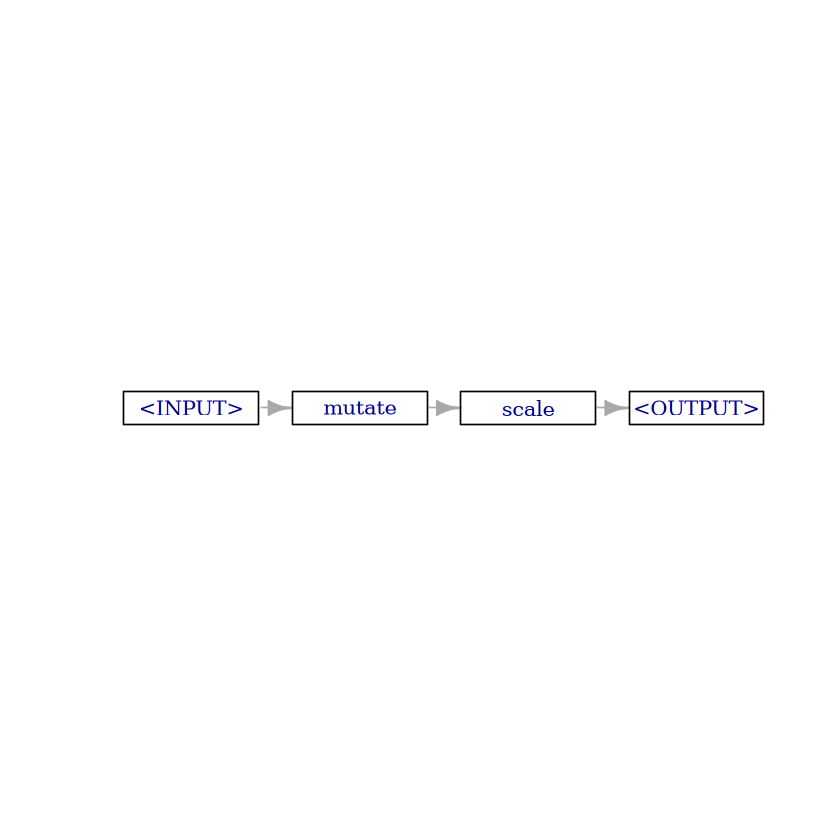

In [15]:
graph$plot(horiz = TRUE)

In [ ]:
graph$pipeops

# $mutate
# PipeOp: <mutate> (not trained)
# values: <mutation=<list>, delete_originals=FALSE>
# Input channels <name [train type, predict type]>:
#   input [Task,Task]
# Output channels <name [train type, predict type]>:
#   output [Task,Task]

# $scale
# PipeOp: <scale> (not trained)
# values: <robust=FALSE>
# Input channels <name [train type, predict type]>:
#   input [Task,Task]
# Output channels <name [train type, predict type]>:
#   output [Task,Task]

$mutate
PipeOp: <mutate> (not trained)
values: <mutation=<list>, delete_originals=FALSE>
Input channels <name [train type, predict type]>:
  input [Task,Task]
Output channels <name [train type, predict type]>:
  output [Task,Task]

$scale
PipeOp: <scale> (not trained)
values: <robust=FALSE>
Input channels <name [train type, predict type]>:
  input [Task,Task]
Output channels <name [train type, predict type]>:
  output [Task,Task]


In [ ]:
graph$edges

# src_id src_channel dst_id dst_channel
# 1 mutate output      scale  input

src_id,src_channel,dst_id,dst_channel
<chr>,<chr>,<chr>,<chr>
mutate,output,scale,input


In [19]:
library(mlr3pipelines)

In [20]:
graph <- Graph$new()$
  add_pipeop(po_mutate)$
  add_pipeop(po_scale)$
  add_edge("mutate", "scale")

In [ ]:
result <- graph$train(tsk_small)
result

# $scale.output
# <TaskClassif:penguins> (333 x 4): Simplified Palmer Penguins
# * Target: species
# * Properties: multiclass
# * Features (3):
#   - dbl (3): bill_depth, bill_length, bill_ration

$scale.output
<TaskClassif:penguins> (333 x 4): Simplified Palmer Penguins
* Target: species
* Properties: multiclass
* Features (3):
  - dbl (3): bill_depth, bill_length, bill_ration


In [ ]:
result[[1]]$data()[1:3]

# species bill_depth bill_length bill_ration
# 1 Adelie  0.7795590  -0.8946955  -1.0421499 
# 2 Adelie  0.1194043  -0.8215515  -0.6804365 
# 3 Adelie  0.4240910  -0.6752636  -0.7434640

species,bill_depth,bill_length,bill_ration
<fct>,<dbl>,<dbl>,<dbl>
Adelie,0.7795590,-0.8946955,-1.0421499
Adelie,0.1194043,-0.8215515,-0.6804365
Adelie,0.4240910,-0.6752636,-0.7434640


In [ ]:
result <- graph$predict(tsk_onepenguin)
result[[1]]$data()

# species bill_depth bill_length bill_ration
# 1 Adelie  0.9319023  -0.5289757  -0.8963212

species,bill_depth,bill_length,bill_ration
<fct>,<dbl>,<dbl>,<dbl>
Adelie,0.9319023,-0.5289757,-0.8963212


# 顺序学习器管道

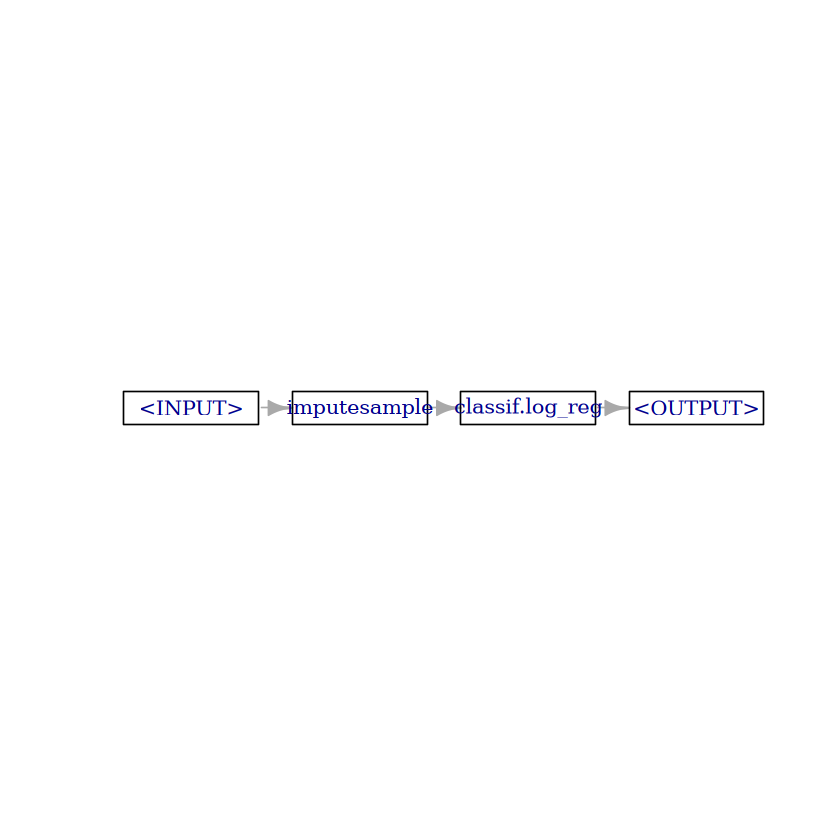

In [25]:
lrn_logreg <- lrn("classif.log_reg", predict_type = "prob")
graph <- po("imputesample") %>>%
  lrn_logreg

graph$plot(horiz = TRUE)

In [ ]:
glrn_sample <- as_learner(graph)
glrn_mode <- as_learner(po("imputemode") %>>% lrn_logreg)

design <- benchmark_grid(
  tasks = tsk("pima"),
  learners = list(glrn_sample, glrn_mode),
  resamplings = rsmp("cv", folds = 3)
)

bmr <- benchmark(design)

aggr <- bmr$aggregate()[, .(learner_id, classif.ce)]
aggr

# learner_id                   classif.ce
# 1 imputesample.classif.log_reg 0.2317708 
# 2 imputemode.classif.log_reg   0.2395833

INFO  [19:15:39.592] [mlr3] Running benchmark with 6 resampling iterations
INFO  [19:15:39.672] [mlr3] Applying learner 'imputesample.classif.log_reg' on task 'pima' (iter 1/3)
INFO  [19:15:39.878] [mlr3] Applying learner 'imputesample.classif.log_reg' on task 'pima' (iter 2/3)
INFO  [19:15:39.949] [mlr3] Applying learner 'imputesample.classif.log_reg' on task 'pima' (iter 3/3)
INFO  [19:15:40.048] [mlr3] Applying learner 'imputemode.classif.log_reg' on task 'pima' (iter 1/3)
INFO  [19:15:40.282] [mlr3] Applying learner 'imputemode.classif.log_reg' on task 'pima' (iter 2/3)
INFO  [19:15:40.343] [mlr3] Applying learner 'imputemode.classif.log_reg' on task 'pima' (iter 3/3)
INFO  [19:15:40.406] [mlr3] Finished benchmark


learner_id,classif.ce
<chr>,<dbl>
imputesample.classif.log_reg,0.2317708
imputemode.classif.log_reg,0.2395833


In [27]:
glrn_sample$graph_model$keep_results <- TRUE
glrn_sample$train(tsk("pima"))

In [ ]:
imputesample_output <- glrn_sample$graph_model$pipeops$imputesample$.result
imputesample_output[[1]]$missings()

# diabetes      age pedigree pregnant  glucose  insulin     mass pressure 
#        0        0        0        0        0        0        0        0 
#  triceps 
#        0

diabetes      age pedigree pregnant  glucose  insulin     mass pressure 
       0        0        0        0        0        0        0        0 
 triceps 
       0

In [ ]:
pipeop_logreg <- glrn_sample$graph_model$pipeops$classif.log_reg
learner_logreg <- pipeop_logreg$learner_model
learner_logreg

# <LearnerClassifLogReg:classif.log_reg>: Logistic Regression
# * Model: glm
# * Parameters: use_pred_offset=TRUE
# * Packages: mlr3, mlr3learners, stats
# * Predict Types:  response, [prob]
# * Feature Types: logical, integer, numeric, character, factor, ordered
# * Properties: offset, twoclass, weights

<LearnerClassifLogReg:classif.log_reg>: Logistic Regression
* Model: glm
* Parameters: use_pred_offset=TRUE
* Packages: mlr3, mlr3learners, stats
* Predict Types:  response, [prob]
* Feature Types: logical, integer, numeric, character, factor, ordered
* Properties: offset, twoclass, weights

In [ ]:
graph <- po("scale", center = FALSE, scale = TRUE, id = "scale") %>>%
  po("scale", center = TRUE, scale = FALSE, id = "center") %>>%
  lrn("classif.rpart", cp = 1)
unlist(graph$param_set$values)

# scale.center        scale.scale       scale.robust      center.center 
#                  0                  1                  0                  1 
#       center.scale      center.robust   classif.rpart.cp classif.rpart.xval 
#                  0                  0                  1                  0

scale.center        scale.scale       scale.robust      center.center 
                 0                  1                  0                  1 
      center.scale      center.robust   classif.rpart.cp classif.rpart.xval 
                 0                  0                  1                  0

In [ ]:
graph$param_set$values$classif.rpart.maxdepth <- 5
graph_learner <- as_learner(graph)
graph_learner$param_set$values$classif.rpart.minsplit <- 2
unlist(graph_learner$param_set$values)

# scale.center            scale.scale           scale.robust 
#                      0                      1                      0 
#          center.center           center.scale          center.robust 
#                      1                      0                      0 
#       classif.rpart.cp classif.rpart.maxdepth classif.rpart.minsplit 
#                      1                      5                      2 
#     classif.rpart.xval 
#                      0

scale.center            scale.scale           scale.robust 
                     0                      1                      0 
         center.center           center.scale          center.robust 
                     1                      0                      0 
      classif.rpart.cp classif.rpart.maxdepth classif.rpart.minsplit 
                     1                      5                      2 
    classif.rpart.xval 
                     0

# 练习

## 练习1

In [33]:
graph <- po("imputeoor") %>>%
  po("scale") %>>%
  lrn("classif.log_reg")

glrn <- as_learner(graph)

In [34]:
glrn$train(tsk("pima"))

In [ ]:
# 访问模型
glrn$graph_model$pipeops$classif.log_reg$learner_model$model

# Call:  stats::glm(formula = form, family = "binomial", data = data, 
#     model = FALSE)

# Coefficients:
# (Intercept)          age      glucose      insulin         mass     pedigree  
#    -0.88835      0.15584      1.13631     -0.17477      0.74383      0.32121  
#    pregnant     pressure      triceps  
#     0.39594     -0.24967      0.05599  

# Degrees of Freedom: 767 Total (i.e. Null);  759 Residual
# Null Deviance:	    993.5 
# Residual Deviance: 745.1 	AIC: 763.1


Call:  stats::glm(formula = form, family = "binomial", data = data, 
    model = FALSE)

Coefficients:
(Intercept)          age      glucose      insulin         mass     pedigree  
   -0.88835      0.15584      1.13631     -0.17477      0.74383      0.32121  
   pregnant     pressure      triceps  
    0.39594     -0.24967      0.05599  

Degrees of Freedom: 767 Total (i.e. Null);  759 Residual
Null Deviance:	    993.5 
Residual Deviance: 745.1 	AIC: 763.1

In [ ]:
glrn$model$classif.log_reg$model

# Call:  stats::glm(formula = form, family = "binomial", data = data, 
#     model = FALSE)

# Coefficients:
# (Intercept)          age      glucose      insulin         mass     pedigree  
#    -0.88835      0.15584      1.13631     -0.17477      0.74383      0.32121  
#    pregnant     pressure      triceps  
#     0.39594     -0.24967      0.05599  

# Degrees of Freedom: 767 Total (i.e. Null);  759 Residual
# Null Deviance:	    993.5 
# Residual Deviance: 745.1 	AIC: 763.1


Call:  stats::glm(formula = form, family = "binomial", data = data, 
    model = FALSE)

Coefficients:
(Intercept)          age      glucose      insulin         mass     pedigree  
   -0.88835      0.15584      1.13631     -0.17477      0.74383      0.32121  
   pregnant     pressure      triceps  
    0.39594     -0.24967      0.05599  

Degrees of Freedom: 767 Total (i.e. Null);  759 Residual
Null Deviance:	    993.5 
Residual Deviance: 745.1 	AIC: 763.1

## 练习3

In [ ]:
glrn$model$classif.log_reg$model$data %>% head()

# diabetes age         glucose    insulin    mass       pedigree   pregnant  
# 1 pos       1.42506672  0.7779946 -1.0104646  0.2007435  0.4681869  0.6395305
# 2 neg      -0.19054773 -0.9828928 -1.0104646 -0.4809120 -0.3648230 -0.8443348
# 3 pos      -0.10551539  1.7562654 -1.0104646 -0.8022639  0.6040037  1.2330766
# 4 neg      -1.04087112 -0.8710904  0.8347783 -0.3348430 -0.9201630 -0.8443348
# 5 pos      -0.02048305  0.4705381  0.9843380  1.1258474  5.4813370 -1.1411079
# 6 neg      -0.27558007 -0.1164244 -1.0104646 -0.5782914 -0.8175458  0.3427574
#   pressure     triceps   
# 1  0.190968289  0.7481501
# 2  0.009453876  0.6355978
# 3 -0.051050929 -1.5216538
# 4  0.009453876  0.5230456
# 5 -0.777108583  0.7481501
# 6  0.251473094 -1.5216538

diabetes,age,glucose,insulin,mass,pedigree,pregnant,pressure,triceps
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pos,1.42506672,0.7779946,-1.0104646,0.2007435,0.4681869,0.6395305,0.190968289,0.7481501
neg,-0.19054773,-0.9828928,-1.0104646,-0.4809120,-0.3648230,-0.8443348,0.009453876,0.6355978
pos,-0.10551539,1.7562654,-1.0104646,-0.8022639,0.6040037,1.2330766,-0.051050929,-1.5216538
neg,-1.04087112,-0.8710904,0.8347783,-0.3348430,-0.9201630,-0.8443348,0.009453876,0.5230456
pos,-0.02048305,0.4705381,0.9843380,1.1258474,5.4813370,-1.1411079,-0.777108583,0.7481501
neg,-0.27558007,-0.1164244,-1.0104646,-0.5782914,-0.8175458,0.3427574,0.251473094,-1.5216538


In [ ]:
glrn$model$classif.log_reg$